In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

Define directory paths

In [2]:
# Set up paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Create directories
for directory in [DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Create timestamped run directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = os.path.join(RESULTS_DIR, f'run_{timestamp}')

# Create subdirectories for this run
subdirs = ['metrics', 'predictions', 'training_history', 'model_architecture', 'validation_plots']
for subdir in subdirs:
    os.makedirs(os.path.join(run_dir, subdir), exist_ok=True)

print(f"Results will be saved in: {run_dir}")

Results will be saved in: c:\Users\sasan\Downloads\improved_model\results\run_20241203_003016


In [3]:
def preprocess_data(data):
    """Enhanced data preprocessing with feature engineering and outlier handling"""
    # Feature engineering
    data['radiation_temp'] = data['shortwave_radiation_backwards_sfc'] * data['temperature_2_m_above_gnd']
    data['cloud_impact'] = data['total_cloud_cover_sfc'] * data['shortwave_radiation_backwards_sfc']
    data['wind_power'] = data['wind_speed_10_m_above_gnd'] * data['wind_gust_10_m_above_gnd']
    data['humidity_temp'] = data['relative_humidity_2_m_above_gnd'] * data['temperature_2_m_above_gnd']
    
    # List of numerical columns for outlier removal
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    
    # Remove outliers using IQR method
    for column in numerical_columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    return data

In [4]:
def create_improved_model(input_dim, learning_rate=0.001):
    """Create an improved neural network with better architecture and regularization"""
    inputs = Input(shape=(input_dim,))
    
    # First block
    x = Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    
    # Second block with increased complexity
    x = Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    
    # Third block
    x = Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )
    
    return model

In [5]:
def plot_training_history(history, fold, save_path):
    """Plot and save training history"""
    plt.figure(figsize=(15, 5))
    
    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss (Fold {fold})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'Model MAE (Fold {fold})')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    # Plot training & validation MSE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title(f'Model MSE (Fold {fold})')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'training_history_fold_{fold}.png'))
    plt.close()

def plot_predictions(y_true, y_pred, fold, set_name='Validation', save_path=RESULTS_DIR):
    """Plot prediction scatter plots"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Power Generation (kW)')
    plt.ylabel('Predicted Power Generation (kW)')
    plt.title(f'{set_name} Predictions vs Actual Values (Fold {fold})')
    
    # Add R² score to plot
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f'{set_name.lower()}_predictions_fold_{fold}.png'))
    plt.close()

In [6]:
# Load and preprocess data
print("Loading and preprocessing data...")
data_path = os.path.join(DATA_DIR, 'solarpowergeneration.csv')
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at: {data_path}\nPlease place your data file in: {DATA_DIR}")

data = pd.read_csv(data_path)
data = preprocess_data(data)

# Prepare features and target
X = data.iloc[:, :-1].values  # All columns except the last one
y = data.iloc[:, -1].values.reshape(-1, 1)  # Last column is the target

# Initialize metrics storage
all_metrics = {
    'train_rmse': [], 'test_rmse': [],
    'train_mae': [], 'test_mae': [],
    'train_r2': [], 'test_r2': [],
    'training_time': []
}

print("Data shape:", X.shape)
print("Number of features:", X.shape[1])
print("Number of samples:", X.shape[0])

Loading and preprocessing data...
Data shape: (1509, 24)
Number of features: 24
Number of samples: 1509


In [7]:
# K-fold cross validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
    print(f"\nTraining fold {fold}/{n_splits}")
    
    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Scale features and target
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    
    # Create and train model
    model = create_improved_model(X_train.shape[1])
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            os.path.join(run_dir, 'model_architecture', f'best_model_fold_{fold}.h5'),
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    # Train model
    start_time = datetime.now()
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Save training history plot
    plot_training_history(history, fold, os.path.join(run_dir, 'training_history'))
    
    # Make predictions
    y_train_pred_scaled = model.predict(X_train_scaled)
    y_val_pred_scaled = model.predict(X_val_scaled)
    
    # Inverse transform predictions
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Store metrics
    all_metrics['train_rmse'].append(train_rmse)
    all_metrics['test_rmse'].append(val_rmse)
    all_metrics['train_mae'].append(train_mae)
    all_metrics['test_mae'].append(val_mae)
    all_metrics['train_r2'].append(train_r2)
    all_metrics['test_r2'].append(val_r2)
    all_metrics['training_time'].append(training_time)
    
    # Plot predictions
    plot_predictions(y_train, y_train_pred, fold, 'Training', os.path.join(run_dir, 'validation_plots'))
    plot_predictions(y_val, y_val_pred, fold, 'Validation', os.path.join(run_dir, 'validation_plots'))
    
    # Save fold predictions
    fold_df = pd.DataFrame({
        'Actual_Power': y_val.flatten(),
        'Predicted_Power': y_val_pred.flatten(),
        'Absolute_Error': np.abs(y_val.flatten() - y_val_pred.flatten())
    })
    fold_df.to_csv(os.path.join(run_dir, 'predictions', f'predictions_fold_{fold}.csv'), index=False)
    
    # Print fold metrics
    print(f"\nFold {fold} Results:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")


Training fold 1/5
Epoch 1/200
38/38 [==============================] - 3s 23ms/step - loss: 1.0963 - mae: 0.8095 - mse: 1.0591 - val_loss: 0.5483 - val_mae: 0.5687 - val_mse: 0.5113 - lr: 0.0010
Epoch 2/200
38/38 [==============================] - 0s 10ms/step - loss: 0.8033 - mae: 0.6737 - mse: 0.7664 - val_loss: 0.4971 - val_mae: 0.5423 - val_mse: 0.4603 - lr: 0.0010
Epoch 3/200
38/38 [==============================] - 0s 10ms/step - loss: 0.6225 - mae: 0.6054 - mse: 0.5857 - val_loss: 0.4383 - val_mae: 0.5029 - val_mse: 0.4016 - lr: 0.0010
Epoch 4/200
38/38 [==============================] - 0s 7ms/step - loss: 0.5400 - mae: 0.5648 - mse: 0.5034 - val_loss: 0.3465 - val_mae: 0.4438 - val_mse: 0.3099 - lr: 0.0010
Epoch 5/200
38/38 [==============================] - 0s 10ms/step - loss: 0.5391 - mae: 0.5476 - mse: 0.5026 - val_loss: 0.3345 - val_mae: 0.4329 - val_mse: 0.2981 - lr: 0.0010
Epoch 6/200
38/38 [==============================] - 0s 11ms/step - loss: 0.4771 - mae: 0.5197 - 

In [8]:
# Calculate mean and std of metrics
metrics = {}
for metric in ['train_rmse', 'test_rmse', 'train_mae', 'test_mae', 'train_r2', 'test_r2', 'training_time']:
    values = all_metrics[metric]
    metrics[f'mean_{metric}'] = np.mean(values)
    metrics[f'std_{metric}'] = np.std(values)

# Save final metrics
metrics_file = os.path.join(run_dir, 'metrics', 'model_metrics.csv')
pd.DataFrame([metrics]).to_csv(metrics_file, index=False)

# Also save as readable text file
with open(os.path.join(run_dir, 'metrics', 'model_metrics.txt'), 'w') as f:
    for key, value in metrics.items():
        f.write(f'{key}: {value}\n')

print(f"\nResults saved in: {run_dir}")

# Display directory structure
print("\nDirectory structure:")
for subdir in subdirs:
    files = os.listdir(os.path.join(run_dir, subdir))
    print(f"\n{subdir}/")
    for file in files:
        print(f"  └─ {file}")

# Print final metrics
print("\nFinal Mean Metrics:")
print(f"Mean Training RMSE: {metrics['mean_train_rmse']:.4f} ± {metrics['std_train_rmse']:.4f}")
print(f"Mean Test RMSE: {metrics['mean_test_rmse']:.4f} ± {metrics['std_test_rmse']:.4f}")
print(f"Mean Training MAE: {metrics['mean_train_mae']:.4f} ± {metrics['std_train_mae']:.4f}")
print(f"Mean Test MAE: {metrics['mean_test_mae']:.4f} ± {metrics['std_test_mae']:.4f}")
print(f"Mean Training R²: {metrics['mean_train_r2']:.4f} ± {metrics['std_train_r2']:.4f}")
print(f"Mean Test R²: {metrics['mean_test_r2']:.4f} ± {metrics['std_test_r2']:.4f}")
print(f"Mean Training Time: {metrics['mean_training_time']:.2f} ± {metrics['std_training_time']:.2f} seconds")


Results saved in: c:\Users\sasan\Downloads\improved_model\results\run_20241203_003016

Directory structure:

metrics/
  └─ model_metrics.csv
  └─ model_metrics.txt

predictions/
  └─ predictions_fold_1.csv
  └─ predictions_fold_2.csv
  └─ predictions_fold_3.csv
  └─ predictions_fold_4.csv
  └─ predictions_fold_5.csv

training_history/
  └─ training_history_fold_1.png
  └─ training_history_fold_2.png
  └─ training_history_fold_3.png
  └─ training_history_fold_4.png
  └─ training_history_fold_5.png

model_architecture/
  └─ best_model_fold_1.h5
  └─ best_model_fold_2.h5
  └─ best_model_fold_3.h5
  └─ best_model_fold_4.h5
  └─ best_model_fold_5.h5

validation_plots/
  └─ training_predictions_fold_1.png
  └─ training_predictions_fold_2.png
  └─ training_predictions_fold_3.png
  └─ training_predictions_fold_4.png
  └─ training_predictions_fold_5.png
  └─ validation_predictions_fold_1.png
  └─ validation_predictions_fold_2.png
  └─ validation_predictions_fold_3.png
  └─ validation_predictio

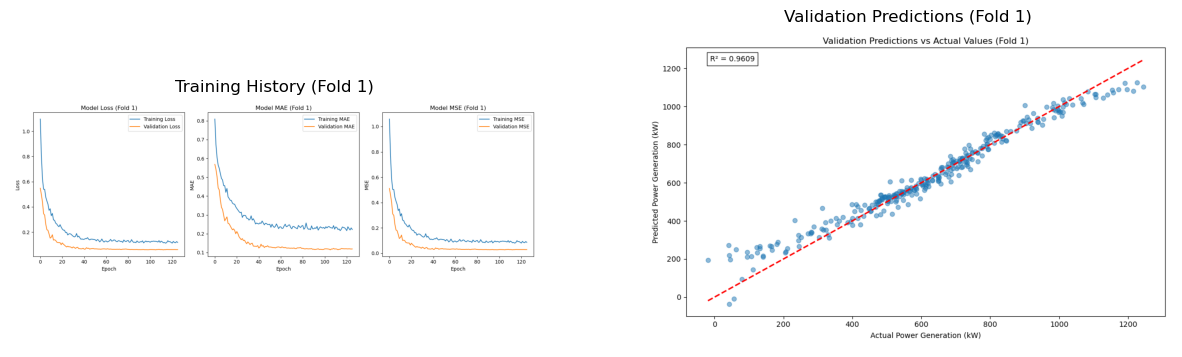

,Value
Metric,
mean_train_rmse,41.354013
std_train_rmse,2.538926
mean_test_rmse,44.689378
std_test_rmse,5.151121
mean_train_mae,29.942959
std_train_mae,1.584284
mean_test_mae,32.238033
std_test_mae,3.275697
mean_train_r2,0.973565


In [9]:
# Display some example plots
plt.figure(figsize=(15, 5))
img1 = plt.imread(os.path.join(run_dir, 'training_history', 'training_history_fold_1.png'))
img2 = plt.imread(os.path.join(run_dir, 'validation_plots', 'validation_predictions_fold_1.png'))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Training History (Fold 1)')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Validation Predictions (Fold 1)')
plt.show()

# Display metrics as a formatted DataFrame
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ['Value']
metrics_df.index.name = 'Metric'
display(metrics_df)